This notebook expands on the simple model to predict ratings for a user, anime pair by adding in an interaction term each user and each item.

rating(user, item) = offset + user_bias + item_bias + dot_product(user_latent_features, item_latent_features)

When formulated this way, this is a natural extension of the linear model from the previous notebook. However, it's actually a bit deceptive what is going on with "latent_features." While a proper explanation is outside the scope of this notebook, the key here is that, as the dot_product indicates, the user and item latent feature terms are vectors. 

What's actually going on in this formulation is a dimensionality reduction problem. What we want to do is essentially embed each of the m users and n items (i.e. anime) in a k-dimensional space. There is no proper label for what these dimensions represent, but similar shows will group nearer to each other, and likewise for users. Since we embed them in the same space, we can take their dot product as a measure of how similar (i.e. compatible) a show and anime pair are. k itself is a hyper-parameter, though I'll begin with 2 because it's good for visualizations.

Therefore, though the formulation above looks similar to the formulation of the linear model, they're actually conceptually quite difference. The objective function will be mean absolute error (MAE) with L2 regularization of all the parameters. This model is implemented in tensorflow, just for the sake of practice. 

Much of this code builds off of the linear model.

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

%matplotlib inline
matplotlib.style.use('seaborn')

In [2]:
from animerec.data import get_data
users, anime = get_data()

In [3]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(users, test_size = 0.1) #let's split up the dataset into a train and test set.
train, valid = train_test_split(train, test_size = 0.2) #let's split up the dataset into a train and valid set.

In [4]:
from animerec.data import remove_users
train = remove_users(train, 10)

In [5]:
#define validation set
valid_users = valid['user_id']
valid_anime = valid['anime_id']
valid_ratings = valid['rating']

In [6]:
#initialize some local variables
nUsers = len(train.user_id.unique())
nAnime = len(train.anime_id.unique())

# we'll need some data structures in order to vectorize computations
from collections import defaultdict
user_ids = train.user_id
item_ids = train.anime_id

user_index = defaultdict(lambda: -1) # maps a user_id to the index in the bias term.
item_index = defaultdict(lambda: -1) # maps an anime_id to the index in the bias term.

counter = 0
for user in user_ids:
    if user_index[user] == -1:
        user_index[user] = counter
        counter += 1 

counter = 0
for item in item_ids:
    if item_index[item] == -1:
        item_index[item] = counter
        counter += 1 

In [7]:
#Terms needed for the latent factors.
k = 3; # hyper-parameter

In [8]:
import tensorflow as tf

In [9]:
y = tf.cast(tf.constant(train['rating'].as_matrix(), shape=[len(train),1]), tf.float32)

In [10]:
def objective(alpha, Bi, Bu, Gi, Gu, y, lam): #Gi, Gu = gamma_i, gamma_u = latent factors for items, users 
    
    '''
    Like in the linear model, we need to construct the "full" matrix for each (user, item) pair. However, with the
    addition of the latent factor terms, it will wasate memory to hold each variable in its own tensor.
    Instead, create one intermediary tensor to represent our prediction ("pred") and simply incrementally add to that
    each additional variable.
    '''
    pred = tf.gather(Bi, train.anime_id.map(lambda _id: item_index[_id]).as_matrix()) #Bi_full
    pred += tf.gather(Bu, train.user_id.map(lambda _id: user_index[_id]).as_matrix()) #Bu_full
    
    Gi_full = tf.gather(Gi, train.anime_id.map(lambda _id: item_index[_id]).as_matrix()) #latent factors of items
    Gu_full = tf.gather(Gu, train.user_id.map(lambda _id: user_index[_id]).as_matrix()) #latent factors of users
    pred += tf.expand_dims(tf.einsum('ij,ji->i', Gi_full, tf.transpose(Gu_full)), 1) # dot product latent factors

    pred += tf.tile(alpha, (len(train), 1)) #alpha_full
    obj = tf.reduce_sum(abs(pred-y))


    # regularization
    obj += lam * tf.reduce_sum(Bi**2)
    obj += lam * tf.reduce_sum(Bu**2) 
    obj += lam * tf.reduce_sum(Gi**2) 
    obj += lam * tf.reduce_sum(Gu**2)
    
    return obj

In [11]:
#initialize alpha, Bi, Bu, Gi, Gu 
alpha = tf.Variable(tf.constant([6.9], shape=[1, 1]))
Bi = tf.Variable(tf.constant([0.0]*nAnime, shape=[nAnime, 1]))
Bu = tf.Variable(tf.constant([0.0]*nUsers, shape=[nUsers, 1]))
Gi = tf.Variable(tf.random_normal([nAnime, k], stddev=0.35))
Gu = tf.Variable(tf.random_normal([nUsers, k], stddev=0.35))

In [12]:
optimizer = tf.train.AdamOptimizer(0.01)

In [13]:
obj = objective(alpha, Bi, Bu, Gi, Gu, y, 1)

In [14]:
trainer = optimizer.minimize(obj)

In [15]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
tLoss = []
vLoss = []
prev = 10e10
for iteration in range(500):
    cvalues = sess.run([trainer, obj])
    print("objective = " + str(cvalues[1]))
    tLoss.append(cvalues[1])
    
    if not iteration % 5:
        cAlpha, cBi, cBu, cGi, cGu, cLoss = sess.run([alpha, Bi, Bu, Gi, Gu, obj])
        indices = valid_users.map(lambda x: user_index[x])
        bu = indices.map(lambda x: 0.0 if x == -1 else float(cBu[x]))
        gu = indices.map(lambda x: np.zeros(k) if x == -1 else cGu[x])
        gu = np.vstack(gu.as_matrix()).astype(np.float)


        indices = valid_anime.map(lambda x: item_index[x])
        bi = indices.map(lambda x: 0.0 if x == -1 else float(cBi[x]))
        gi = indices.map(lambda x: np.zeros(k) if x == -1 else cGi[x])
        gi = np.vstack(gi.as_matrix()).astype(np.float)

        g = np.einsum('ij,ji->i', gi, np.transpose(gu)) 

        preds = bu + bi + g + float(cAlpha)
        MAE = 1.0/len(valid) * sum(abs(valid_ratings-preds))
        vLoss.append(MAE)
        if MAE > prev: break
        else: prev = MAE
    
cAlpha, cBi, cBu, cGi, cGu, cLoss = sess.run([alpha, Bi, Bu, Gi, Gu, obj])
print("\nFinal train loss is ", cLoss)

objective = 3.64655e+06
objective = 3.60087e+06
objective = 3.55697e+06
objective = 3.51536e+06
objective = 3.47668e+06
objective = 3.44132e+06
objective = 3.40894e+06
objective = 3.37898e+06
objective = 3.35093e+06
objective = 3.32431e+06
objective = 3.29878e+06
objective = 3.27407e+06
objective = 3.24997e+06
objective = 3.22632e+06
objective = 3.20299e+06
objective = 3.17991e+06
objective = 3.15698e+06
objective = 3.13414e+06
objective = 3.11133e+06
objective = 3.08852e+06
objective = 3.06565e+06
objective = 3.04268e+06
objective = 3.0196e+06
objective = 2.99637e+06
objective = 2.97297e+06
objective = 2.94938e+06
objective = 2.92562e+06
objective = 2.90168e+06
objective = 2.87759e+06
objective = 2.85342e+06
objective = 2.82924e+06
objective = 2.80517e+06
objective = 2.7814e+06
objective = 2.75812e+06
objective = 2.73558e+06
objective = 2.714e+06
objective = 2.69361e+06
objective = 2.67454e+06
objective = 2.65682e+06
objective = 2.64037e+06
objective = 2.62506e+06
objective = 2.61069e

Let's plot the objective and see how it decreases.

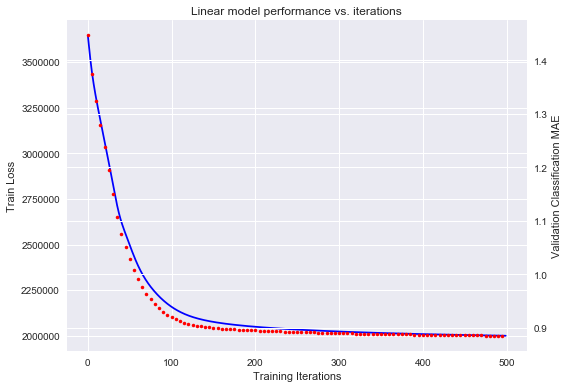

In [16]:
fig, ax1 = plt.subplots()
plt.title('Linear model performance vs. iterations')
ax1.plot(tLoss, 'b-')
ax1.set_xlabel('Training Iterations')
ax1.set_ylabel('Train Loss')

ax2 = ax1.twinx()
ax2.plot(range(0, len(vLoss)*5, 5), vLoss, 'r.')
ax2.set_ylabel('Validation Classification MAE')

fig.tight_layout()

We can see quite clearly that this model does not overfit, just like the linear model. L2 regularization looks to be more than enough. However, we also can see that after about 150 iterations, validation MAE mostly flatlines, which suggests a place for early stopping. 

Let's test the model on our test data now.

In [17]:
test_users = test['user_id']
test_anime = test['anime_id']
test_ratings = test['rating']

In [18]:
indices = test_users.map(lambda x: user_index[x])
bu = indices.map(lambda x: 0.0 if x == -1 else float(cBu[x]))
gu = indices.map(lambda x: np.zeros(k) if x == -1 else cGu[x])
gu = np.vstack(gu.as_matrix()).astype(np.float)

indices = test_anime.map(lambda x: item_index[x])
bi = indices.map(lambda x: 0.0 if x == -1 else float(cBi[x]))
gi = indices.map(lambda x: np.zeros(k) if x == -1 else cGi[x])
gi= np.vstack(gi.as_matrix()).astype(np.float)

g = np.einsum('ij,ji->i', gi, np.transpose(gu)) 

preds = bu + bi + g + float(cAlpha)
MAE = 1.0/len(test) * sum(abs(test_ratings-preds))
print ('MAE on test set is: ', float(MAE))

MAE on test set is:  0.885571453178356


In [19]:
sess.close()

So, an improvement over the linear model, though not by much. But the important thing is that we are now actually running a recommender system. The linear model would recommend the same shows to everyone, but now we have a legitimate interaction between users and items.

We could likely improve on this by tuning our hyperparameters.